In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [2]:
TRAIN_DIR = "./Vegetable Images/train"
TEST_DIR = "./Vegetable Images/test"
VALIDATION_DIR = "./Vegetable Images/validation"

batch_size = 120
img_height, img_width = 256, 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 15000 files belonging to 15 classes.
Using 12000 files for training.
Metal device set to: Apple M1 Max


2023-02-06 00:48:55.038518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-06 00:48:55.038662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 3000 files belonging to 15 classes.
Using 2400 files for training.
Found 3000 files belonging to 15 classes.
Using 2400 files for training.


In [5]:
class_names = train_ds.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

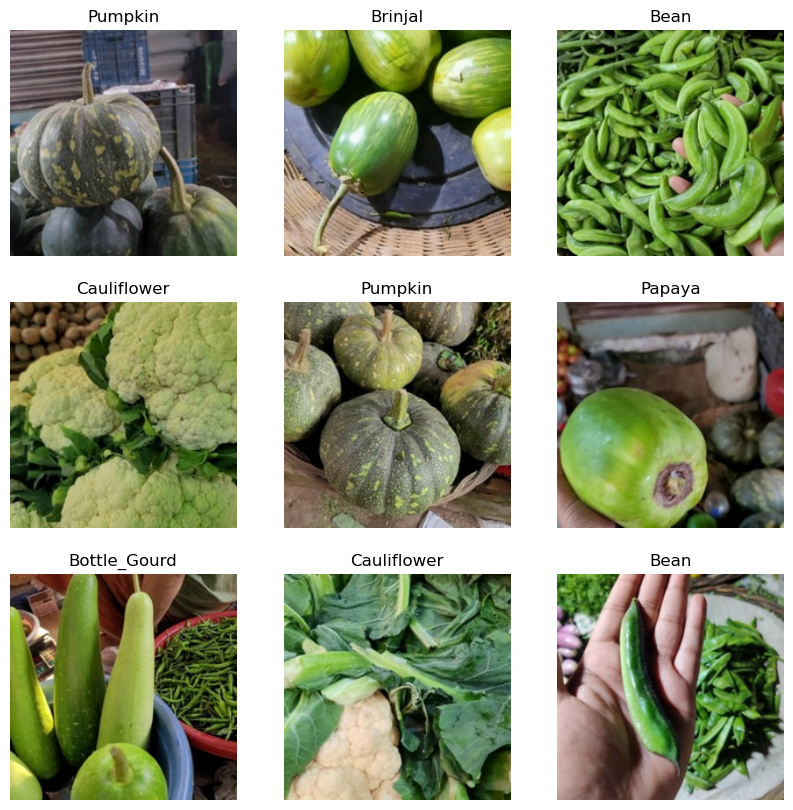

In [7]:
import matplotlib.pyplot as plt

#See sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [18]:
x = tf.keras.layers.Input([256, 256, 3], dtype=tf.uint8)

pretrained = tf.keras.applications.MobileNetV3Small(input_shape=[256, 256, 3], include_top=False,
                                                    classifier_activation="softmax")
model2 = tf.keras.models.Sequential([
    tf.keras.applications.mobilenet_v3.preprocess_input(x),
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 8, 8, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 512)               295424    
                                                                 
 dense_15 (Dense)            (None, 64)                32832     
                                                                 
 dense_16 (Dense)            (None, 15)                975       
                                                                 
Total params: 1,268,351
Trainable params: 1,256,239
No

In [19]:
callbacks = tf.keras.callbacks.ModelCheckpoint("vegetable.h5", save_best_only=True)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=callbacks)

Epoch 1/20


2023-02-06 01:10:20.354286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 8.0715 - accuracy: 0.2013

2023-02-06 01:10:58.375343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 41s 379ms/step - loss: 8.0715 - accuracy: 0.2013 - val_loss: 2.0745 - val_accuracy: 0.3367
Epoch 2/20
100/100 [==============================] - 60s 587ms/step - loss: 1.7849 - accuracy: 0.4238 - val_loss: 1.6267 - val_accuracy: 0.4854
Epoch 3/20
100/100 [==============================] - 63s 635ms/step - loss: 1.1890 - accuracy: 0.6194 - val_loss: 1.4084 - val_accuracy: 0.5625
Epoch 4/20
100/100 [==============================] - 62s 617ms/step - loss: 0.8378 - accuracy: 0.7353 - val_loss: 1.4270 - val_accuracy: 0.5646
Epoch 5/20
100/100 [==============================] - 60s 596ms/step - loss: 0.5913 - accuracy: 0.8175 - val_loss: 1.4146 - val_accuracy: 0.6113
Epoch 6/20
100/100 [==============================] - 55s 540ms/step - loss: 0.4047 - accuracy: 0.8758 - val_loss: 1.5119 - val_accuracy: 0.5983
Epoch 7/20
100/100 [==============================] - 55s 551ms/step - loss: 0.2769 - accuracy: 0.9169 - val_loss: 1.4759 - val_accuracy: 0.6

In [35]:
callbacks = tf.keras.callbacks.ModelCheckpoint("vegetable2.h5", save_best_only=True)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=callbacks)

Epoch 1/20


2023-02-06 01:33:25.685672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9577

2023-02-06 01:34:01.789132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 42s 298ms/step - loss: 0.1579 - accuracy: 0.9577 - val_loss: 1.7827 - val_accuracy: 0.6633
Epoch 2/20
100/100 [==============================] - 22s 216ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.5644 - val_accuracy: 0.8838
Epoch 3/20
100/100 [==============================] - 21s 205ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.4541 - val_accuracy: 0.8958
Epoch 4/20
100/100 [==============================] - 21s 209ms/step - loss: 0.0214 - accuracy: 0.9942 - val_loss: 2.3358 - val_accuracy: 0.7988
Epoch 5/20
100/100 [==============================] - 22s 221ms/step - loss: 0.0080 - accuracy: 0.9974 - val_loss: 4.0385 - val_accuracy: 0.7846
Epoch 6/20
100/100 [==============================] - 21s 212ms/step - loss: 0.0119 - accuracy: 0.9972 - val_loss: 1.7086 - val_accuracy: 0.8321
Epoch 7/20
100/100 [==============================] - 20s 202ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 4.5970 - val_accuracy: 0.7

In [36]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,8.071476,0.201333,2.074456,0.336667
1,1.784900,0.423833,1.626720,0.485417
2,1.188998,0.619417,1.408410,0.562500
3,0.837847,0.735333,1.426977,0.564583
4,0.591305,0.817500,1.414622,0.611250
5,0.404652,0.875833,1.511933,0.598333
6,0.276873,0.916917,1.475936,0.621250
7,0.165499,0.953500,1.571681,0.648750
8,0.124729,0.965583,1.761791,0.628333
9,0.098892,0.972833,1.815006,0.643750


In [37]:
history_df2 = pd.DataFrame(history2.history)
history_df2

,loss,accuracy,val_loss,val_accuracy
0,0.157889,0.957750,1.782679,0.663333
1,0.004270,0.999000,0.564362,0.883750
2,0.005976,0.998167,0.454065,0.895833
3,0.021374,0.994250,2.335779,0.798750
4,0.007999,0.997417,4.038509,0.784583
5,0.011912,0.997167,1.708606,0.832083
6,0.011548,0.997000,4.596970,0.720833
7,0.015365,0.995667,1.967890,0.879583
8,0.006854,0.997750,1.328128,0.892500
9,0.010212,0.997333,1.475167,0.899583


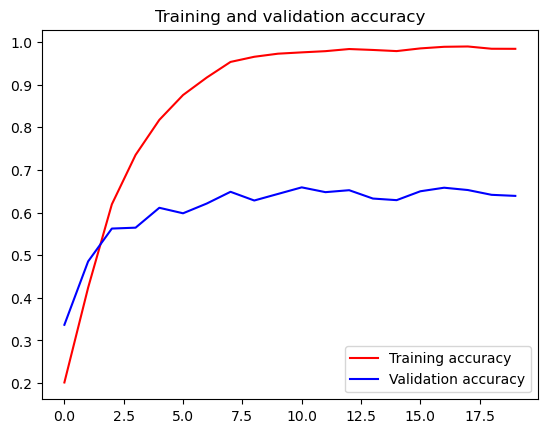

<Figure size 640x480 with 0 Axes>

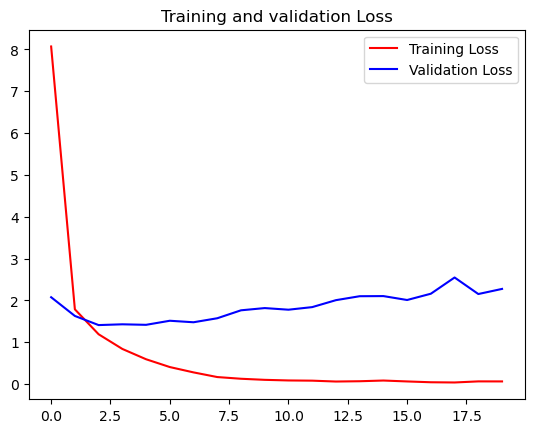

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy - Model 1')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss - Model 1')
plt.legend(loc=0)
plt.figure()

plt.show()

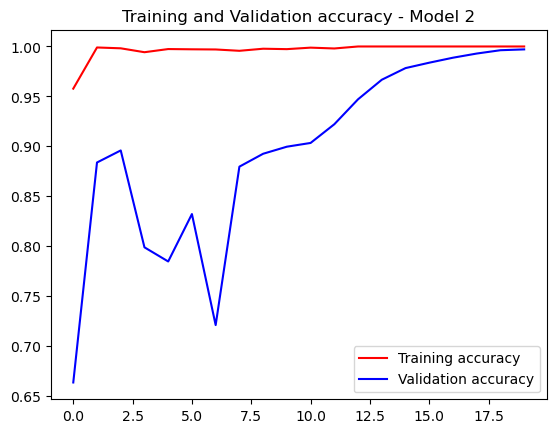

<Figure size 640x480 with 0 Axes>

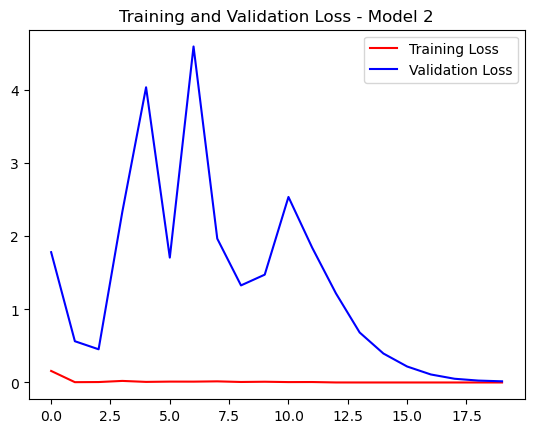

<Figure size 640x480 with 0 Axes>

In [38]:
# Plot the results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy - Model 2')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss - Model 2')
plt.legend(loc=0)
plt.figure()

plt.show()

In [43]:
model_path = "./vegetable2.h5"
model = tf.keras.models.load_model(model_path)
# model.summary()
val_loss, val_acc = model.evaluate(validation_ds)
print(f"Validation Accuracy: {val_acc}.3f")

2023-02-06 01:46:42.966100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 95ms/step - loss: 0.0394 - accuracy: 0.9958
Validation Accuracy: 0.9958333373069763.3f


In [44]:
model = tf.keras.models.load_model("vegetable2.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open("vegetable2.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/89/wy7_qkjn4dz1y9trj8f2mmvw0000gn/T/tmpickeu7qv/assets


INFO:tensorflow:Assets written to: /var/folders/89/wy7_qkjn4dz1y9trj8f2mmvw0000gn/T/tmpickeu7qv/assets
2023-02-06 01:49:02.309169: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-06 01:49:02.309186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-06 01:49:02.310242: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/89/wy7_qkjn4dz1y9trj8f2mmvw0000gn/T/tmpickeu7qv
2023-02-06 01:49:02.332564: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-06 01:49:02.332583: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/89/wy7_qkjn4dz1y9trj8f2mmvw0000gn/T/tmpickeu7qv
2023-02-06 01:49:02.411206: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-06 01:49:02.770617: I tensorflow/cc/saved_model/loader.cc:213] Running initialization